In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
%pip install scikit-opt
from sko.PSO import PSO
import numpy as np
from scipy.fft import dct, idct
import matplotlib as mpl

mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold'  

Note: you may need to restart the kernel to use updated packages.


# Rosenbrock function

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

# ----------- 2D NDCT Basis + Fit + Predict -----------
def ndct2_basis(x, y, Kx, Ky):
    x = np.asarray(x).reshape(-1)
    y = np.asarray(y).reshape(-1)
    kx = np.arange(Kx + 1)
    ky = np.arange(Ky + 1)

    A = []
    for i in kx:
        for j in ky:
            A.append(np.cos(np.pi * x * i) * np.cos(np.pi * y * j))
    return np.vstack(A).T

def ndct2_fit(x, y, z, Kx, Ky, lam=0.0):
    A = ndct2_basis(x, y, Kx, Ky)
    n = A.shape[1]
    if lam and lam > 0:
        ATA = A.T @ A
        ATz = A.T @ z
        c = np.linalg.solve(ATA + lam*np.eye(n), ATz)
    else:
        c = np.linalg.lstsq(A, z, rcond=None)[0]
    return c.reshape(Kx+1, Ky+1)

def ndct2_predict(X, Y, coeffs):
    Kx, Ky = coeffs.shape[0]-1, coeffs.shape[1]-1
    Zhat = np.zeros_like(X, dtype=float)
    for i in range(Kx+1):
        for j in range(Ky+1):
            Zhat += coeffs[i, j] * np.cos(np.pi * i * X) * np.cos(np.pi * j * Y)
    return Zhat

# ----------- Demo: Rosenbrock 函数 -----------
N = 20
x_lin = np.linspace(0.1, 1.9, N)
y_lin = np.linspace(0.1, 1.9, N)
X, Y = np.meshgrid(x_lin, y_lin)


X_flat = X.flatten()
Y_flat = Y.flatten()
M = X_flat.shape[0]
np.random.seed(0) 

m = 200
idx = np.random.choice(M, m, replace=False)
x_samples = X_flat[idx]
y_samples = Y_flat[idx]
z_samples = (1 - x_samples)**2 + 100*(y_samples - x_samples**2)**2

sigma = 0  
z_samples = z_samples + np.random.normal(0, sigma, size=z_samples.shape)

x_scaled = x_samples / 2
y_scaled = y_samples / 2



C:\Users\16941\AppData\Local\Temp\ipykernel_106388\1771086060.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper left')


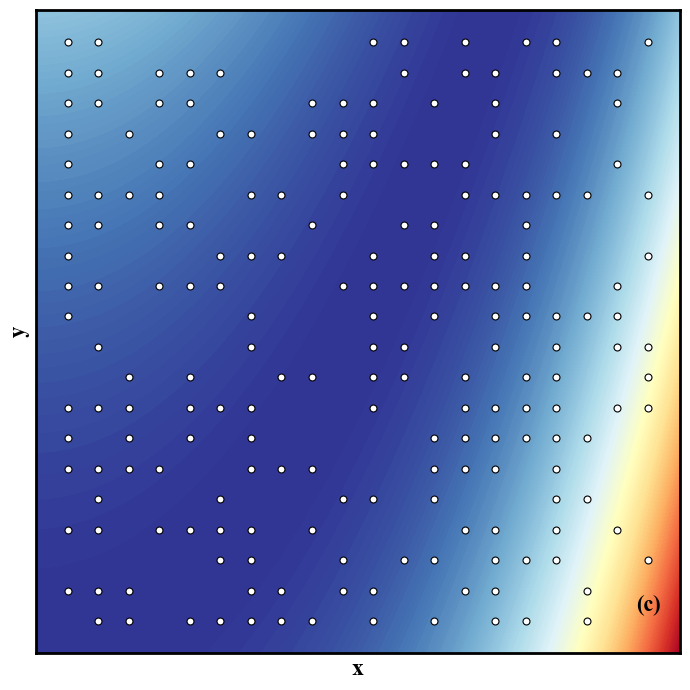

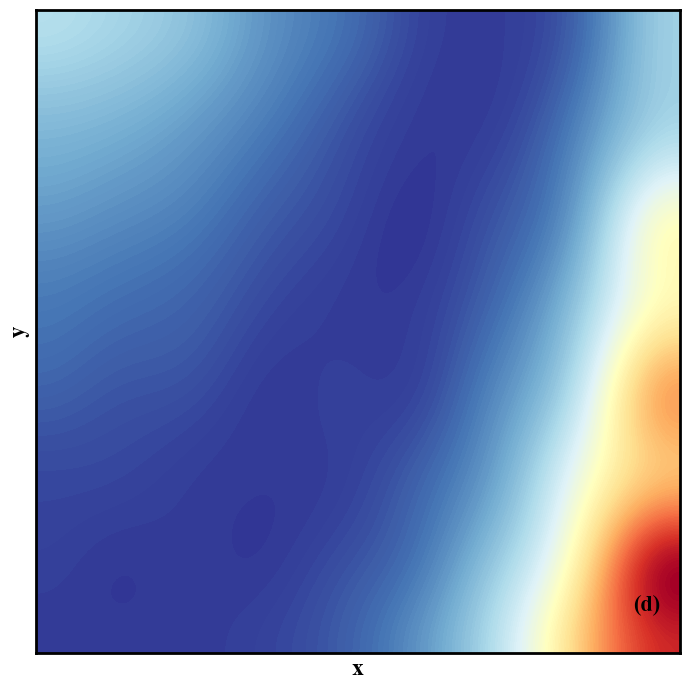

In [ ]:

t = 8
Kx, Ky = t, t
coeffs = ndct2_fit(x_scaled, y_scaled, z_samples, Kx, Ky, lam=1e-6)


Xg, Yg = np.meshgrid(np.linspace(0,2,200), np.linspace(0,2,200))
Xg_scaled = Xg / 2
Yg_scaled = Yg / 2
Zhat = ndct2_predict(Xg_scaled, Yg_scaled, coeffs)


Ztrue = (1 - Xg)**2 + 100*(Yg - Xg**2)**2


fig, ax = plt.subplots(figsize=(7,7))
cs0 = ax.contourf(Xg, Yg, Ztrue, levels=200, cmap="RdYlBu_r")
ax.scatter(x_samples, y_samples, facecolors='white', edgecolors='black',
           s=25, linewidths=0.8, marker='o')
ax.set_xlabel('x', fontweight="bold", fontsize=17); ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(c)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")
ax.legend(frameon=False, loc='upper left')

ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(figsize=(7,7))
cs1 = ax.contourf(Xg, Yg, Zhat, levels=200, cmap="RdYlBu_r")
ax.set_xlabel('x', fontweight="bold", fontsize=17); ax.set_ylabel('y', fontweight="bold", fontsize=16)
ax.text(0.97, 0.09, "(d)", transform=ax.transAxes,
        fontsize=16, fontweight="bold", ha="right", va="top")

ax.set_xticks([]); ax.set_yticks([])
ax.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)


for spine in ax.spines.values():
    spine.set_linewidth(2)
plt.tight_layout()
plt.show()

In [ ]:
def ndct2_objective(Xin):
    """
    Xin: shape (2,) 或 (pop, 2) ; 返回标量或一维数组
    作用: 在 [0,2]^2 上取点 (x,y)，内部按 /2 归一化到 [0,1] 后，
         用 NDCT 系数 coeffs 预测 Zhat，并取负作为 PSO 的目标。
    """
    A = np.asarray(Xin, dtype=float)
    Kx, Ky = coeffs.shape[0]-1, coeffs.shape[1]-1
    i = np.arange(Kx+1)
    j = np.arange(Ky+1)

    if A.ndim == 1:
        x, y = A
        xs, ys = x/2.0, y/2.0
        cx = np.cos(np.pi * xs * i)             # (Kx+1,)
        cy = np.cos(np.pi * ys * j)             # (Ky+1,)
        z  = cx @ coeffs @ cy                   
        return float(z)                      
    else:
        X = A[:, 0]; Y = A[:, 1]                # (pop,)
        xs, ys = X/2.0, Y/2.0
        Cx = np.cos(np.pi * xs[:, None] * i[None, :])   # (pop, Kx+1)
        Cy = np.cos(np.pi * ys[:, None] * j[None, :])   # (pop, Ky+1)
        R  = Cy @ coeffs.T                               # (pop, Kx+1)
        z  = np.sum(Cx * R, axis=1)                      # (pop,)
        return z                                       
# 2D modified PSO
from pso_new import PSO_new

pso2 = PSO_new(
    func=ndct2_objective, n_dim=2, pop=30, max_iter=151,
    lb=[0.0, 0.0], ub=[2.0, 2.0],

    w_min=0.4, w_max=0.9,

    beta_center=0.3, sigma_pert=0.01, anneal_pert=True,

    de_interval=10, de_rate=0.25, de_F=0.5, de_CR=0.9,
    verbose=False
)
pso2.record_mode = True
best_xy, best_neg = pso2.run(precision=1e-6, N=20, stop_mode="fitness")  
best_val = -float(best_neg)   
print("best (x,y):", np.round(best_xy, 6), "  best surrogate value:", best_val)

best (x,y): [1.152745 1.32013 ]   best surrogate value: 4.732313153776795


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------- Rosenbrock function --------------------------
def rosenbrock(x, y):
    return (1 - x) ** 2 + 100 * (y - x ** 2) ** 2


N_grid = 20        
N_samples = 200    
K_list = [7,8,9] # Kx=Ky
noise_levels = [0, 0.01, 0.05, 0.1, 0.2, 0.3]
n_repeats = 10

results = []

for K in K_list:
    for noise_level in noise_levels:
        for seed in range(n_repeats):
           
            unique_seed = K * 1000 + int(noise_level * 100) * 100 + seed
            np.random.seed(unique_seed)

            -
            x_lin = np.linspace(0.1, 1.9, N_grid)
            y_lin = np.linspace(0.1, 1.9, N_grid)
            Xg, Yg = np.meshgrid(x_lin, y_lin)
            X_flat = Xg.flatten()
            Y_flat = Yg.flatten()

            idx = np.random.choice(X_flat.shape[0], N_samples, replace=False)
            x_samples = X_flat[idx]
            y_samples = Y_flat[idx]
            z_true = rosenbrock(x_samples, y_samples)

           
            z_samples = z_true + np.random.normal(0, noise_level, size=z_true.shape)

            
            x_scaled = x_samples / 2
            y_scaled = y_samples / 2
            coeffs = ndct2_fit(x_scaled, y_scaled, z_samples, K, K, lam=1e-6)

            
            def ndct_predict_func(vec):
                x, y = vec
                return ndct2_predict(np.array([x/2]), np.array([y/2]), coeffs)[0]

            
            pso = PSO_new(
                func=ndct_predict_func, n_dim=2, pop=20, max_iter=50,
                lb=[0, 0], ub=[2, 2],
                w_min=0.4, w_max=0.9,
                beta_center=0.3, sigma_pert=0.01, anneal_pert=True,
                de_interval=10, de_rate=0.25, de_F=0.5, de_CR=0.9,
                verbose=False,
            )
            pso.record_mode = True
            best_xy, best_val = pso.run(precision=1e-6)

           
            best_x, best_y = best_xy
            dist_to_opt = np.sqrt((best_x - 1) ** 2 + (best_y - 1) ** 2)
            obj_val = best_val  

            # 存储结果
            results.append({
                "Kx": K,
                "Ky": K,
                "Noise": noise_level,
                "Seed": seed,
                "Best_x": best_x,
                "Best_y": best_y,
                "Dist_to_Opt": dist_to_opt,
                "ObjVal": obj_val
            })

df_results = pd.DataFrame(results)
df_results.to_csv("pso_ndct_rosenbrock_resultsnoise.csv", index=False)


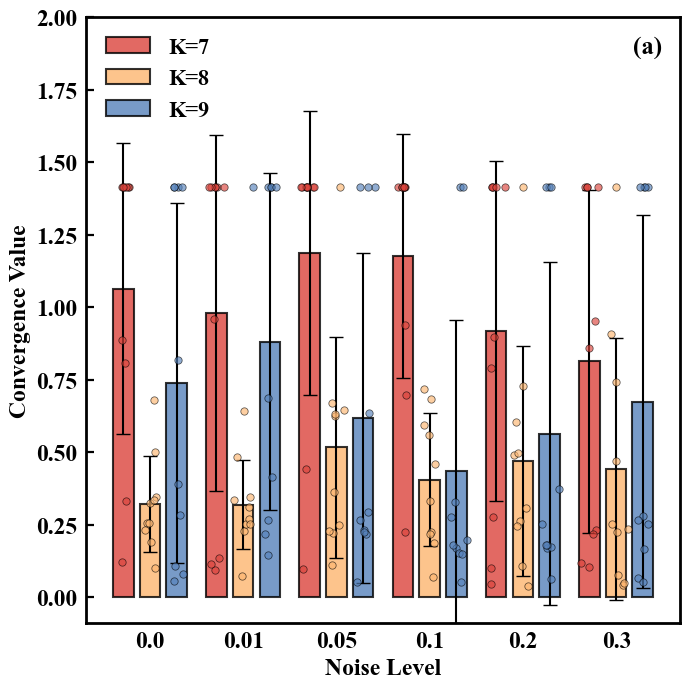

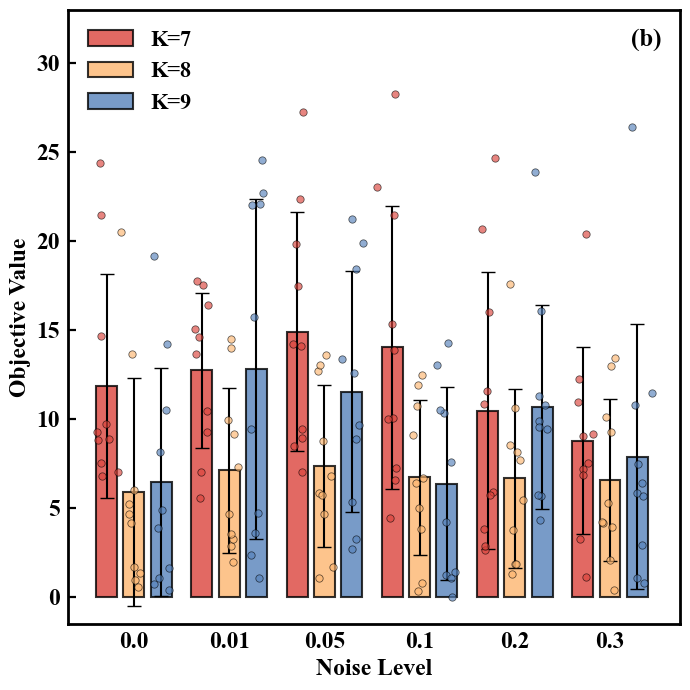

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast

df_raw = pd.read_csv("pso_ndct_rosenbrock_resultsnoise.csv") 
df_results = df_raw.copy()  

def parse_objval(x):
    """把字符串 '[...]' 或单值转成 float"""
    if isinstance(x, str):
        val = ast.literal_eval(x) 
        if isinstance(val, (list, tuple, np.ndarray)):
            return float(val[0])  
        return float(val)
    return float(x)

df_results["ObjVal"] = (df_results["ObjVal"].apply(parse_objval)).abs()


df_results["Best_x"] = df_results["Best_x"].apply(parse_objval)
df_results["Best_y"] = df_results["Best_y"].apply(parse_objval)
df_results["K_dct"] = df_results["Kx"].astype(int)


def plot_multiK_with_scatter(df, col, ylabel, fname=None, tag=None, ymargin=0.2, ylim=None):
    df_summary = df.groupby(["Noise", "K_dct"], as_index=False).agg(
        Mean=(col, "mean"), Std=(col, "std")
    )
    noise_order = sorted(df["Noise"].unique())
    k_order = sorted(df["K_dct"].unique())
    xpos = np.arange(len(noise_order))

    fig, ax = plt.subplots(figsize=(7, 7))
    bar_width = 0.22
    color_map = {7: "#DB443C", 8: "#FDB670", 9: "#5682BB"}

    for j, k in enumerate(k_order):
        means, stds = [], []
        for n in noise_order:
            subset = df_summary[(df_summary["Noise"] == n) & (df_summary["K_dct"] == k)]
            if len(subset) > 0:
                means.append(float(subset["Mean"].iloc[0]))
                stds.append(float(subset["Std"].iloc[0]))
            else:
                means.append(np.nan)
                stds.append(np.nan)

        bar_pos = xpos + (j - len(k_order) / 2) * bar_width * 1.3

        ax.bar(
            bar_pos, means, yerr=stds, capsize=5,
            width=bar_width, color=color_map.get(k, "#999999"),
            edgecolor="black", linewidth=1.5, alpha=0.8,
            label=f"K={k}"
        )

        for i, n in enumerate(noise_order):
            vals = df.loc[(df["Noise"] == n) & (df["K_dct"] == k), col].to_numpy(dtype=float)
            if len(vals) > 0:
                x_jit = np.random.normal(loc=bar_pos[i], scale=0.05, size=vals.shape[0])
                ax.scatter(
                    x_jit, vals,
                    color=color_map.get(k, "#999999"), s=28, alpha=0.65, zorder=3,
                    edgecolor="black", linewidth=0.55
                )

    offset = -0.14  
    ax.set_xticks(xpos + offset)
    ax.set_xticklabels([str(n) for n in noise_order])
    ax.set_xlabel("Noise Level", fontsize=17, fontweight="bold", family="Times New Roman")
    ax.set_ylabel(ylabel, fontsize=17, fontweight="bold", family="Times New Roman")
    ax.tick_params(axis='both', direction='in', which='both',
                   labelsize=17, width=1.6, length=6, pad=6)
    for spine in ax.spines.values():
        spine.set_linewidth(2)
    ax.legend(fontsize=16, frameon=False)

    ymin, ymax = ax.get_ylim()
    ax.set_ylim(ymin, ymax * (1 + ymargin))
    
    if ylim:
        ax.set_ylim(ylim)

    if tag:
        ax.text(0.97, 0.97, tag, transform=ax.transAxes,
                ha="right", va="top", fontsize=18, fontweight="bold")

    
    ax.tick_params(axis="x", bottom=False, top=False)
    plt.tight_layout()
    if fname:
        plt.savefig(fname, dpi=600, bbox_inches="tight")
    plt.show()

plot_multiK_with_scatter(
    df_results, "Dist_to_Opt",
    "Convergence Value",
    "multiK_dist_to_opt.svg",
    tag="(a)",
    ylim=(-0.09, 2),
)

plot_multiK_with_scatter(
    df_results, "ObjVal",
    "Objective Value",
    "multiK_objval.svg",
    tag="(b)",
    ylim=(-1.5, 33)
)
